# House Price Prediction (Linear Regression & Decision Tree Regression)

## Context
Data source, goal, etc

**Dataset:**<br>
<a href="https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/discussion?sort=undefined"> House Sales in King County, USA (Kaggle)</a>
<br><br>

**Column Definitions:**<br>
id - Unique ID for each home sold <br>
date - Date of the home sale <br>
price - Price of each home sold <br>
bedrooms - Number of bedrooms <br>
bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower <br>
sqft_living - Square footage of the apartments interior living space <br>
sqft_lot - Square footage of the land space <br>
floors - Number of floors (0.5 = split-level or bi-level floors)<br>
waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not <br>
view - An index from 0 to 4 of how good the view of the property was <br>
condition - An index from 1 to 5 on the condition of the apartment <br>
grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. <br>
sqft_above - The square footage of the interior housing space that is above ground level <br>
sqft_basement - The square footage of the interior housing space that is below ground level <br>
yr_built - The year the house was initially built <br>
yr_renovated - The year of the house’s last renovation <br>
zipcode - What zipcode area the house is in <br>
lat - Lattitude <br>
long - Longitude <br>
sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors <br>
sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors <br>

verified from 2 sources: <br>
https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices <br>
https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html

## To do List:
1. Go back and preprocess the data properly, dummy variables before scaling and consider whether or not categorical values need to be scaled because they probably don't/shouldn't be scaled.
2. Output of the estimated coefficients?
3. Some kind of plot of the model's performance? How might I do this with multiple input variables 


## Set up

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set()

In [3]:
data = pd.read_csv("../data/kc_house_data.csv")
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,1955,0,47.5112,-122.257,1340,5650,3
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,3
2,180000.0,2,1.00,770,10000,1.0,6,770,0,1933,0,47.7379,-122.233,2720,8062,3
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,1965,0,47.5208,-122.393,1360,5000,5
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,1987,0,47.6168,-122.045,1800,7503,3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   grade          21613 non-null  int64  
 7   sqft_above     21613 non-null  int64  
 8   sqft_basement  21613 non-null  int64  
 9   yr_built       21613 non-null  int64  
 10  yr_renovated   21613 non-null  int64  
 11  lat            21613 non-null  float64
 12  long           21613 non-null  float64
 13  sqft_living15  21613 non-null  int64  
 14  sqft_lot15     21613 non-null  int64  
 15  condition      21613 non-null  int64  
dtypes: float64(5), int64(11)
memory usage: 2.6 MB


In [5]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.401822e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652,3.409430
std,3.673622e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631,0.650743
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000,3.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000,3.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000,4.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,5.000000


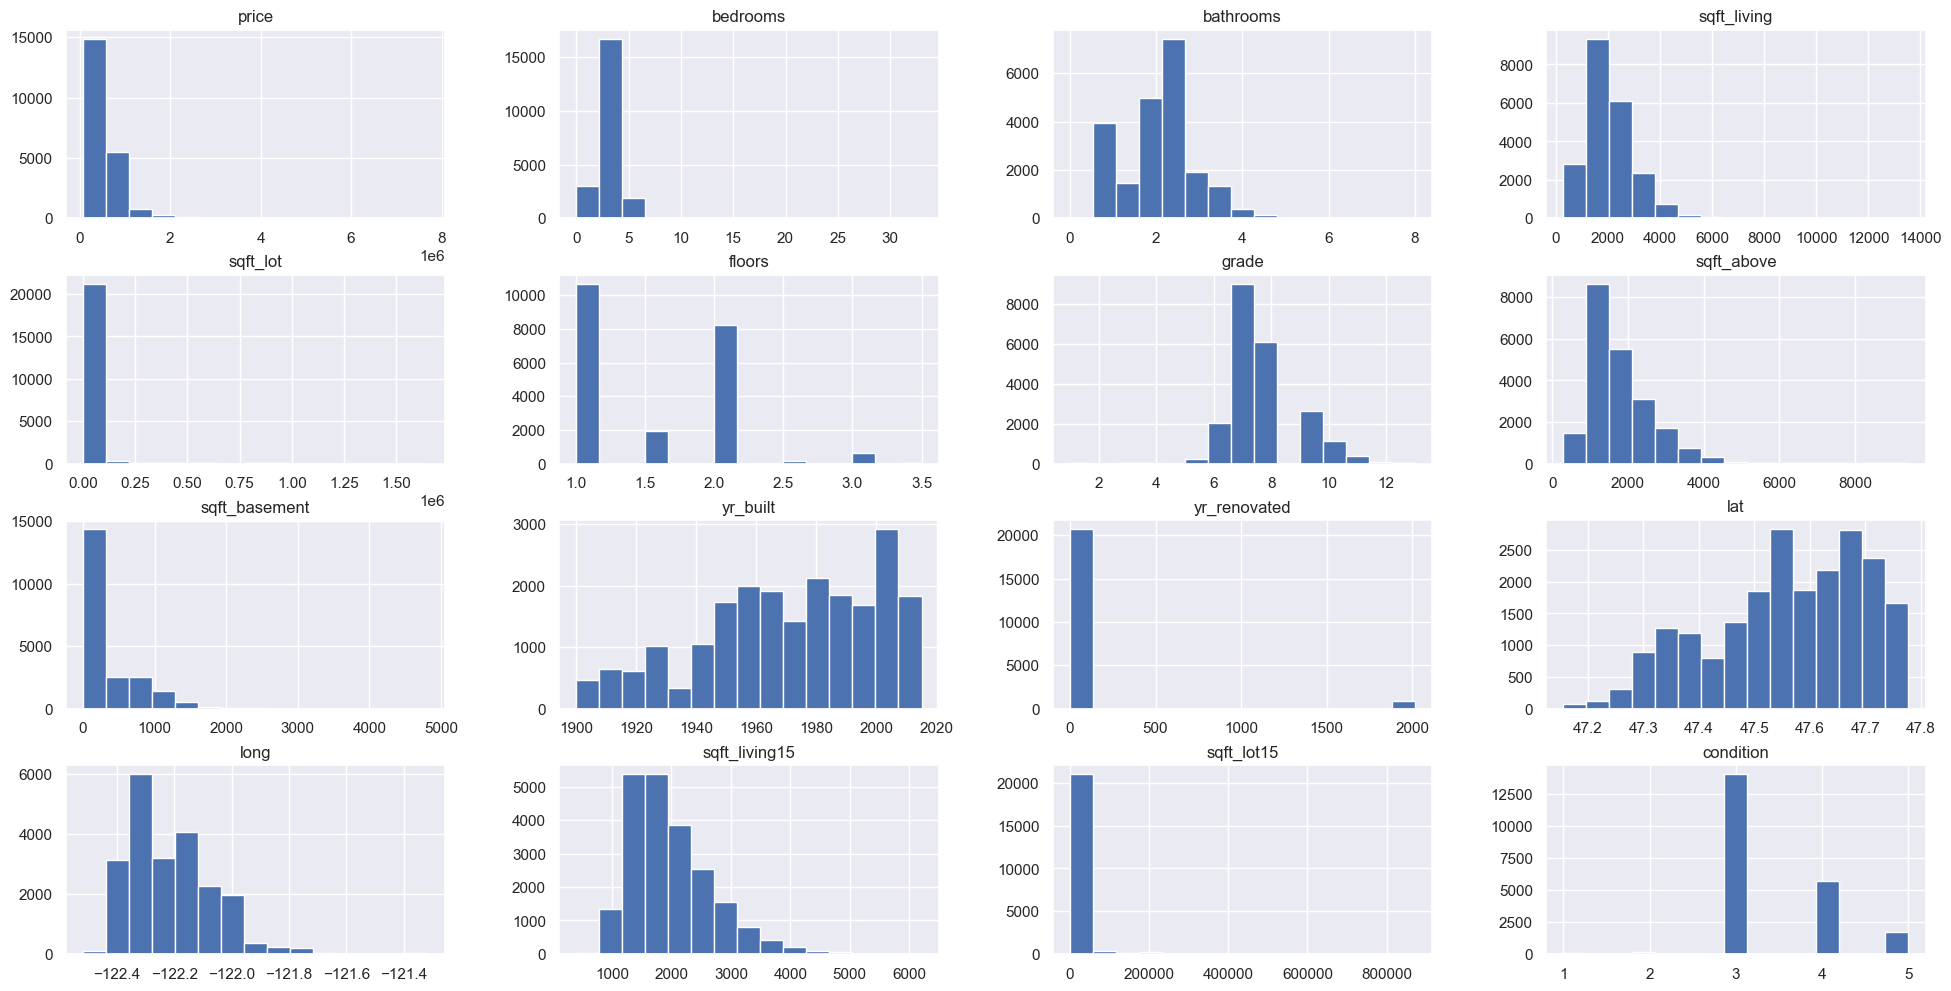

In [6]:
data.hist(bins=15, figsize=(24,12));

In [110]:
# Train test split before any further exploration to avoid any "data snooping" bias
train_set, test_set = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
price_df = train_set.copy()

## EDA

In [8]:
# Quick use function that will plot a number of scatter plots against price, depending on the range of columns I pass
def plot_scatter(col_start=1, col_stop=4):
    fig, axs = plt.subplots(1, (col_stop-col_start+1), figsize=(50,10))
    
    plot_cols = price_df.columns[col_start:col_stop+1]
    
    for i, col in enumerate(plot_cols):
        sns.scatterplot(data=price_df,
                        x=col,
                        y='price',
                        ax=axs[i])

''

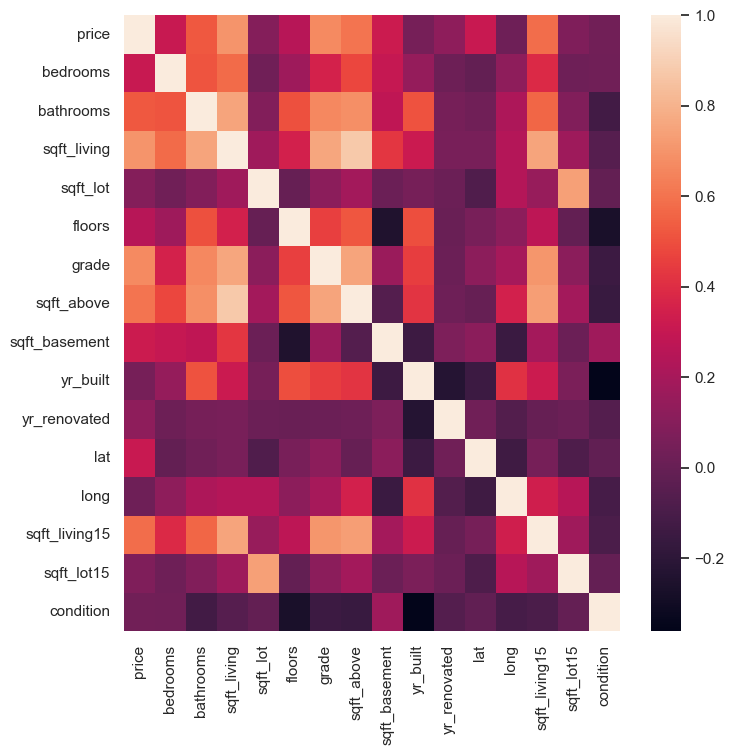

In [9]:
# Quick look at potentially interesting linear relationships
plt.figure(figsize=(8,8))
sns.heatmap(price_df.corr())
;

''

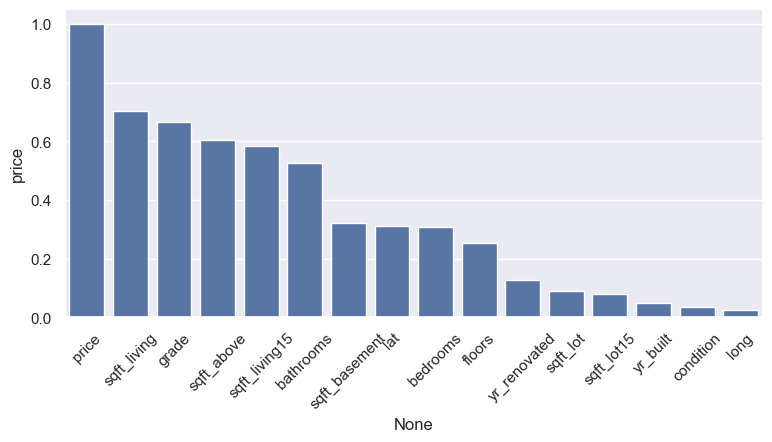

In [10]:
# Ordered bar chart of Pearson correlation coefs
corr_matrix = price_df.corr()[['price']].sort_values('price', ascending=False)

plt.subplots(figsize=(9,4))
plt.xticks(rotation=45)

sns.barplot(x=corr_matrix.index, y=corr_matrix['price'])
;

<Axes: xlabel='sqft_living', ylabel='price'>

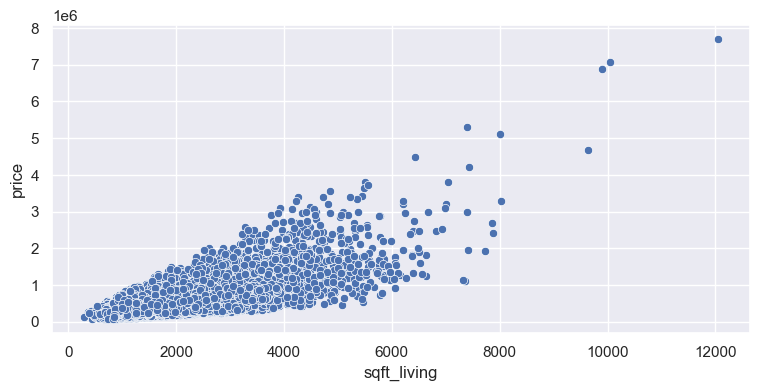

In [11]:
plt.figure(figsize=(9,4))

sns.scatterplot(data=price_df,
               x='sqft_living',
               y='price')

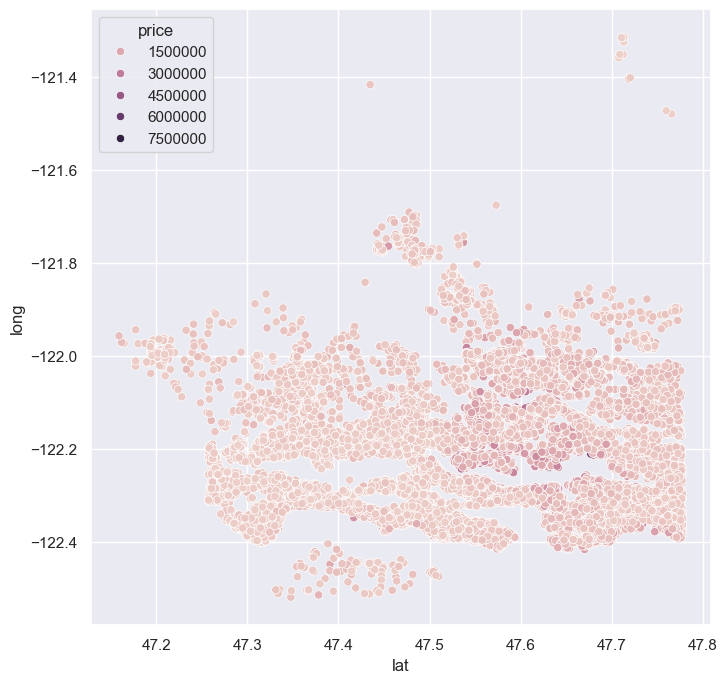

In [12]:
# Heat map of house prices relative to their location

plt.figure(figsize=(8,8))
sns.scatterplot(data=price_df, x='lat', y='long', hue='price');

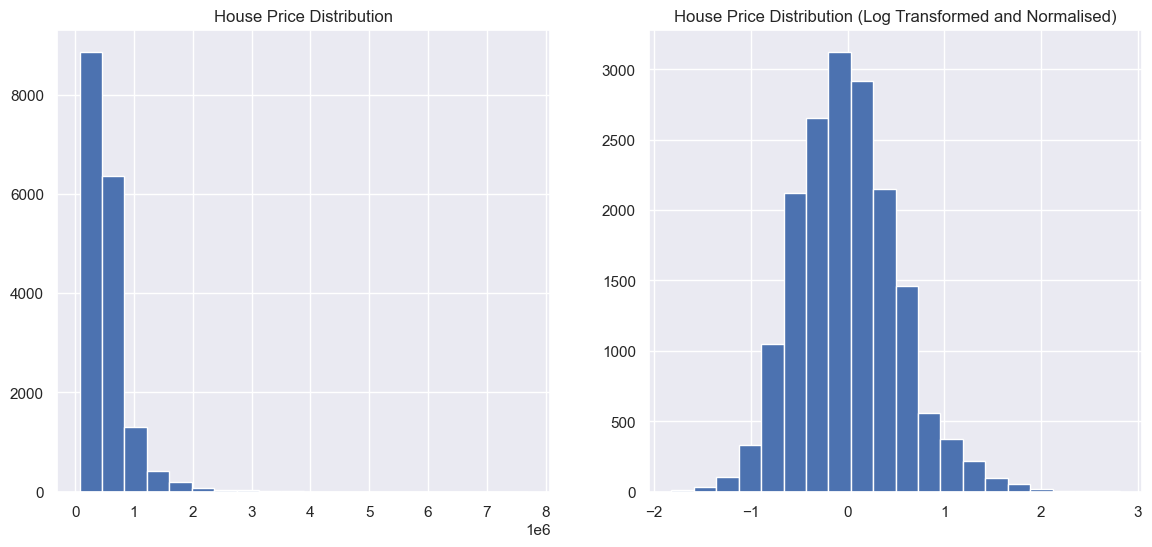

In [47]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))


# #tst_million = price_df['price'] /1_000_000
# tst_log = np.log(price_df['price'])
# tst_mean_norm = tst_log - np.mean(tst_log)

# # tst_mean_norm.hist(bins=20)

# ax1.hist(price_df['price'], bins=20)
# ax2.hist(tst_mean_norm, bins=20)

# ax1.title.set_text("House Price Distribution")
# ax2.title.set_text("House Price Distribution (Log Transformed and Normalised)")
# plt.show();

## Preprocessing & Feature Engineering

In [111]:
print(price_df.shape)
price_df.head()

(17290, 16)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
6325,325000.0,3,1.75,1780,13095,1.0,9,1780,0,1983,0,47.3670,-122.152,2750,13095,4
13473,257000.0,2,1.00,1000,3700,1.0,6,800,200,1929,0,47.5520,-122.290,1270,5000,3
17614,228500.0,3,1.00,1080,7486,1.5,6,990,90,1942,0,47.4838,-122.335,1170,7800,3
16970,288000.0,3,2.25,2090,7500,1.0,7,1280,810,1977,0,47.3951,-122.172,1800,7350,4
20868,479000.0,2,2.50,1741,1439,2.0,8,1446,295,2007,0,47.7043,-122.209,2090,10454,3


In [112]:
# Categoricals to be encoded
    # Already encoded: bedrooms, bathrooms, floors, grade, condition
    # These have already been encoded but may need to be adjusted to 0-based encoding if it provides more consistency across the categorical variables or simply performs better with sklearn's algorithms
    # Many of them will need to be transformed so that floats are rounded up for simplicity. I.e., 1.5 bathrooms represents 1 bathroom and an en suite bathroom but this can be considered as 2 bathrooms
    # In the case of floors, 1.5 floors may be one floor and a loft but this can be rounded down to 1 floor, perhaps.
    
# Numeric: I Assume the rest will be numeric and simply needs to be scaled. I am using linear regression and this algorithm will utilise gradient decent to optimise parameter estimates. 
# Continous features that have varying magnitudes need to be scaled to avoid causing issues (such as much slower convergence rates or leading to suboptimal solutions. I don't think suboptimal solutions is as much of an issue here as LR's loss func is convex. 
# Do I need to scale the target variable?

In [113]:
# Checking the distribution of bedrooms
price_df['bedrooms'].value_counts()

3     7865
4     5477
2     2237
5     1292
6      212
1      153
7       29
8        9
0        8
9        5
10       2
33       1
Name: bedrooms, dtype: int64

In [114]:
# Any instances that have less than 1 bedroom or more than 6 bedrooms will be removed
# upper limit set by ~3 standard deviations above the mean

rooms_3_std = 3 * np.std(price_df['bedrooms'])
rooms_3_std_above = price_df['bedrooms'].mean() + rooms_3_std


print(f"Houses that have more than {round(rooms_3_std_above)} rooms are 3 standard deviations above the mean and will be removed.")
price_df = price_df[price_df['bedrooms'] <= 6]

Houses that have more than 6 rooms are 3 standard deviations above the mean and will be removed.


In [115]:
# Checking the distribution of bedrooms
price_df['bathrooms'].value_counts()

2.50    4330
1.00    3088
1.75    2424
2.25    1618
2.00    1525
1.50    1172
2.75     958
3.00     589
3.50     571
3.25     475
3.75     119
4.00     105
4.50      80
4.25      58
0.75      54
4.75      17
5.00      16
5.25      11
1.25       8
0.00       7
5.50       6
0.50       4
6.00       3
6.25       1
7.75       1
8.00       1
5.75       1
6.75       1
6.50       1
Name: bathrooms, dtype: int64

In [116]:
# All values for bathrooms will be rounded down as decimal values represent rooms with a toilet but no shower.
# Any instances that have less than 1 bathroom or more than 5 bathrooms will be removed
# Upper limit set by ~3 standard deviations above the mean

price_df['bathrooms'] = price_df['bathrooms'].round().astype(int)
price_df.head()

bath_3_std = 3 * np.std(price_df['bathrooms'])
bath_3_std_above = price_df['bathrooms'].mean() + rooms_3_std

print(f"Houses that have more than {round(bath_3_std_above)} bathrooms are 3 standard deviations above the mean and will be removed.")
price_df = price_df[price_df['bathrooms'] <= 5]

Houses that have more than 5 bathrooms are 3 standard deviations above the mean and will be removed.


In [117]:
# Checking the distribution of floors
price_df['floors'].value_counts()

1.0    8472
2.0    6591
1.5    1519
3.0     517
2.5     124
3.5       6
Name: floors, dtype: int64

In [130]:
# As homes with .5 floors are defined as split-level or bi-level floors they will be rounded up for simplicity
price_df['floors'] = price_df['floors'].round().astype(int)

In [132]:
# Checking the distribution of grade (no changes will be made)
price_df['grade'].value_counts()

7     7183
8     4864
9     2068
6     1619
10     911
11     296
5      188
12      64
4       26
13       6
3        3
1        1
Name: grade, dtype: int64

In [133]:
# Checking the distribution of condition (no changes will be made)
price_df['condition'].value_counts()

3    11205
4     4499
5     1359
2      139
1       27
Name: condition, dtype: int64

In [ ]:
######################## Check continuous variables for any inconsistencies or glaring outliers and scale them ########################
# Should I include long and lat????

## Baseline Model
- Do I use the Ridge and Lasso with cross_val_score or do I simply use RidgeCV and LassoCV?

In [118]:
X = train_set.drop('price', axis=1) 
y = train_set[['price']]

scaled_X = StandardScaler().fit_transform(X)

In [119]:
lasso_reg = Lasso(max_iter=1_000)
cross_val = KFold(n_splits=5, shuffle=True, random_state=42)

In [120]:
# K-fold validation with 5 folds and MSE as the error metric
lasso_scores_mse = cross_val_score(estimator=lasso_reg, 
                                   X=scaled_X,
                                   y=y,
                                   scoring='neg_mean_squared_error',
                                   cv=cross_val)

C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+13, tolerance: 1.850e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e+13, tolerance: 1.843e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+13, toleranc

In [121]:
# Average RMSE across all validation folds
np.mean(np.sqrt(-lasso_scores_mse))

211412.44349653422

In [122]:
# K-fold validation with 5 folds and R-squared as the error metric
lasso_scores_r2 = cross_val_score(estimator=lasso_reg, 
                                  X=scaled_X,
                                  y=y,
                                  scoring='r2',
                                  cv=cross_val)

C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+13, tolerance: 1.850e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e+13, tolerance: 1.843e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+13, toleranc

In [123]:
lasso_scores_r2

array([0.66460764, 0.65221359, 0.6556978 , 0.65386689, 0.65834164])

In [151]:
# K-fold validation with 5 folds and R-squared as the error metric (using preprocessed data)

X = price_df.drop('price', axis=1) 
y = price_df[['price']]

# scaled_X = StandardScaler().fit_transform(X)
continuous_feat = [x for x in list(price_df.columns) if x.startswith("sqft_") or x.startswith("yr_") or x.startswith("lat") or x.startswith("long")]
scaled_cont = StandardScaler().fit_transform(price_df[continuous_feat])
for i, col in enumerate(continuous_feat):
    X[col] = scaled_cont.transpose()[i]


lasso_reg = Lasso(max_iter=1_000)
cross_val = KFold(n_splits=5, shuffle=True, random_state=42)

lasso_scores_r2 = cross_val_score(estimator=lasso_reg, 
                                  X=X,
                                  y=y,
                                  scoring='r2',
                                  cv=cross_val)

lasso_scores_r2

C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e+13, tolerance: 1.669e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e+13, tolerance: 1.612e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e+13, toleranc

array([0.66072952, 0.66665024, 0.6620659 , 0.67939246, 0.64019895])

In [144]:
#sqft_ and yr_ and lat and long

[x for x in list(price_df.columns) if x.startswith("sqft_") or x.startswith("yr_") or x.startswith("lat") or x.startswith("long")]

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

array([[-3.21137526e-01, -4.30153387e-02,  1.06358046e-04, ...,
         4.41632601e-01,  1.13355751e+00,  1.54100179e-02],
       [-1.19922335e+00, -2.88214285e-01, -1.20999736e+00, ...,
        -5.40076798e-01, -1.04768807e+00, -2.86592541e-01],
       [-1.10916327e+00, -1.89403938e-01, -9.75385415e-01, ...,
        -8.60199428e-01, -1.19506953e+00, -1.82132113e-01],
       ...,
       [ 6.16178328e-02, -2.60027498e-01,  4.19938261e-01, ...,
         1.29529295e+00, -4.28685947e-01, -3.74264686e-01],
       [-1.89718901e+00,  6.70302135e-03, -1.72861324e+00, ...,
        -7.74833393e-01, -1.19506953e+00,  8.64804163e-02],
       [ 1.19862640e+00, -2.28212968e-01,  1.66708597e+00, ...,
         8.18665922e-01,  1.53148745e+00, -2.49397167e-01]])

In [124]:
ridge_reg = Ridge(max_iter=1_000)

In [125]:
# K-fold validation with 5 folds and MSE as the error metric
ridge_scores_mse = cross_val_score(estimator=ridge_reg, 
                        X=scaled_X,
                        y=y,
                        scoring='neg_mean_squared_error',
                        cv=cross_val)

In [126]:
np.sqrt(-ridge_scores_mse)

array([199923.34623228, 205135.00367688, 218559.76337126, 235962.28835915,
       197480.63897419])

In [127]:
# K-fold validation with 5 folds and R-squared as the error metric
ridge_scores_r2 = cross_val_score(estimator=ridge_reg, 
                                  X=scaled_X,
                                  y=y,
                                  scoring='r2',
                                  cv=cross_val)

In [128]:
ridge_scores_r2

array([0.66460979, 0.6522202 , 0.65569475, 0.65386285, 0.65834485])

## Further iterations
- Cross-validate: Use LassoCV to automatically find an optimal α value.
- What is the duality gap? (difference between the solver's precision and the tolerance?)
- Consider switching to ridge regression as apparently lasso can behave erratically when there are features that are strongly correlated.

## Generalisation Error Test

## Further Development